INFO:pypsa.network.io:New version 1.0.7 available! (Current: 0.35.2)
INFO:pypsa.network.io:Imported network 'PyPSA-Eur' has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.network.io:New version 1.0.7 available! (Current: 0.35.2)
INFO:pypsa.network.io:Imported network 'PyPSA-Eur' has buses, carriers, generators, links, loads, storage_units


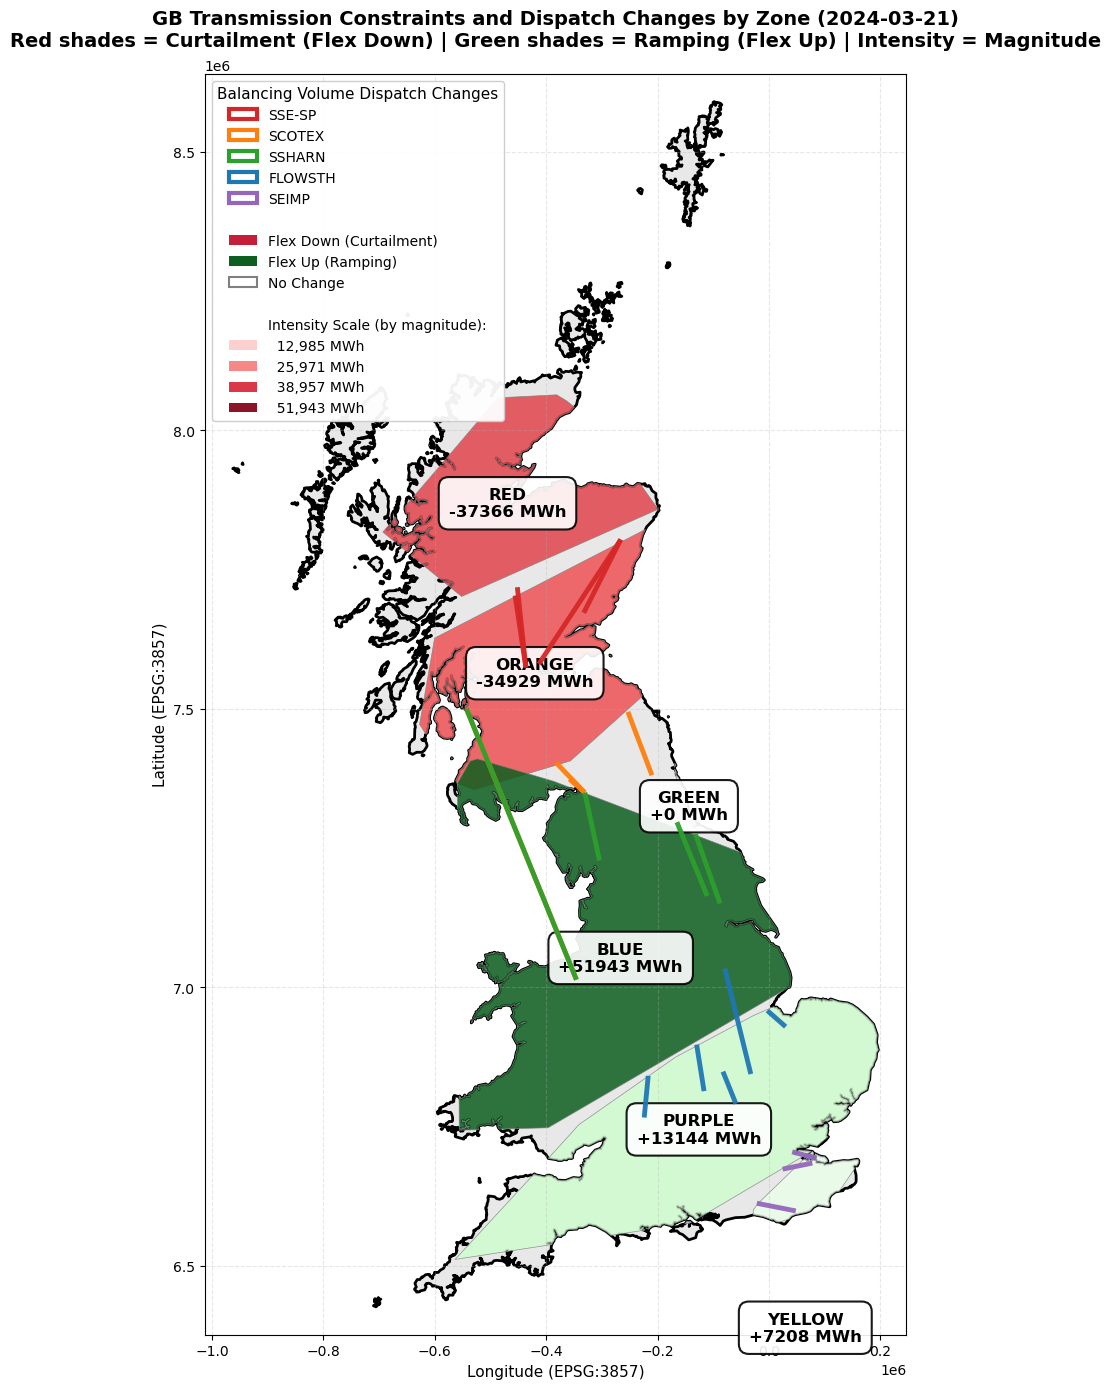


DISPATCH CHANGES BY ZONE - SUMMARY
  zone  count_generators  total_change_mwh  avg_change_per_generator  flex_up_mwh  flex_down_mwh                zone_name
   red                49         -37366.40                   -762.58         0.00      -37366.40          North of SSE-SP
orange                74         -34929.13                   -472.02         0.00      -34929.13         SSE-SP to SCOTEX
 green                13              0.00                      0.00         0.00           0.00         SCOTEX to SSHARN
  blue                92          51943.40                    564.60     52355.79        -412.38        SSHARN to FLOWSTH
purple                53          13144.15                    248.00     14880.30       -1736.15         FLOWSTH to SEIMP
yellow                21           7207.97                    343.24      7207.97           0.00 South of all constraints

Max magnitude: 51943.40 MWh
Total flex up: 72295.52 MWh
Total flex down: -72295.53 MWh


In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap, Normalize
from shapely.geometry import LineString, Polygon, box
import yaml
import pypsa
from pathlib import Path
import matplotlib.cm as cm
import warnings

# Suppress PyPSA version warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# =============================================================================
# LOAD DATA
# =============================================================================

# Load dispatch changes by zone
dispatch_changes = pd.read_csv(
    Path.cwd().parent / 'results' / '2024-03-21' / 'IV_2_dispatch_changes_by_zone_flex.csv'
)

# Load constraint classification to understand geographic zones
bmu_class = pd.read_csv(
    Path.cwd().parent / 'data' / 'prerun' / 'bmu_constraint_classification.csv',
    index_col=0
)

# Load transmission boundaries (actual constraint lines)
with open(Path.cwd().parent / 'data' / 'transmission_boundaries.yaml') as f:
    boundaries = yaml.safe_load(f)

# Load network and GB shape
n_nodal = pypsa.Network(
    Path.cwd().parent / 'results' / '2024-03-21' / 'network_flex_s_nodal.nc'
)
n_national = pypsa.Network(
    Path.cwd().parent / 'results' / '2024-03-21' / 'network_flex_s.nc'
)
gb_shape = gpd.read_file(Path.cwd().parent / 'data' / 'gb_shape.geojson')

# =============================================================================
# CREATE ZONE POLYGONS CLIPPED TO GB BOUNDARY
# =============================================================================

def create_zone_polygon_clipped(bmu_class_df, gb_boundary, zone_name):
    """Create a polygon for each zone based on BMU locations, clipped to GB boundary."""
    
    # Map zone names to classification logic
    if zone_name == 'red':
        mask = (bmu_class_df['SSE-SP_side'] == 'north')
    elif zone_name == 'orange':
        mask = (bmu_class_df['SSE-SP_side'] == 'south') & (bmu_class_df['SCOTEX_side'] == 'north')
    elif zone_name == 'green':
        mask = (bmu_class_df['SCOTEX_side'] == 'south') & (bmu_class_df['SSHARN_side'] == 'north')
    elif zone_name == 'blue':
        mask = (bmu_class_df['SSHARN_side'] == 'south') & (bmu_class_df['FLOWSTH_side'] == 'north')
    elif zone_name == 'purple':
        mask = (bmu_class_df['FLOWSTH_side'] == 'south') & (bmu_class_df['SEIMP_side'] == 'north')
    elif zone_name == 'yellow':
        mask = (bmu_class_df['SEIMP_side'] == 'south')
    else:
        return None
    
    zone_bmus = bmu_class_df[mask]
    if len(zone_bmus) == 0:
        return None
    
    # Get coordinates of BMUs in this zone
    zone_coords = zone_bmus[['lon', 'lat']].copy()
    zone_coords['lat'] = pd.to_numeric(zone_coords['lat'], errors='coerce')
    zone_coords['lon'] = pd.to_numeric(zone_coords['lon'], errors='coerce')
    zone_coords = zone_coords.dropna()
    
    if len(zone_coords) < 3:
        return None
    
    # Create convex hull of BMU points
    from shapely.geometry import MultiPoint
    points = MultiPoint([(lon, lat) for lon, lat in zip(zone_coords['lon'], zone_coords['lat'])])
    polygon = points.convex_hull
    
    # Clip to GB boundary using union_all instead of deprecated unary_union
    try:
        gb_boundary_geom = gb_boundary.geometry.union_all()
    except AttributeError:
        gb_boundary_geom = gb_boundary.unary_union
    
    polygon_clipped = polygon.intersection(gb_boundary_geom)
    
    return polygon_clipped if polygon_clipped.is_valid and not polygon_clipped.is_empty else None

# Create zone polygons clipped to GB
zone_order = ['red', 'orange', 'green', 'blue', 'purple', 'yellow']
zone_polygons = {}

for zone in zone_order:
    poly = create_zone_polygon_clipped(bmu_class, gb_shape, zone)
    if poly is not None:
        zone_polygons[zone] = poly

# =============================================================================
# CREATE COLORMAPS
# =============================================================================

# Create custom colormaps with intensity based on magnitude
# Red colormap: white (0) -> dark red (max)
red_cmap = LinearSegmentedColormap.from_list(
    'red_intensity',
    ['#ffffff', '#fee5e5', '#fcbcbc', '#f68989', '#f05555', '#c41e3a', '#8b1428']
)

# Green colormap: white (0) -> dark green (max)
green_cmap = LinearSegmentedColormap.from_list(
    'green_intensity',
    ['#ffffff', '#e5fee5', '#bcfcbc', '#89f689', '#55f055', '#1e8b34', '#0d5f1f']
)

# =============================================================================
# CREATE FIGURE
# =============================================================================

fig, ax = plt.subplots(1, 1, figsize=(16, 14))

# Plot GB shape as background (light gray)
gb_shape_proj = gb_shape.to_crs('EPSG:3857')
gb_shape_proj.plot(ax=ax, facecolor='#e8e8e8', edgecolor='black', linewidth=2, zorder=0)

# Get bounds of GB shape for setting axis limits
minx, miny, maxx, maxy = gb_shape_proj.total_bounds
ax.set_xlim(minx - 50000, maxx + 50000)
ax.set_ylim(miny - 50000, maxy + 50000)

# =============================================================================
# PLOT ZONE POLYGONS WITH DISPATCH CHANGES (CLIPPED TO GB)
# =============================================================================

# Prepare data for plotting
zone_data = dispatch_changes[dispatch_changes['zone'] != 'unknown'].copy()

# Find max magnitude for normalization
max_flex_up = zone_data[zone_data['total_change_mwh'] > 0]['total_change_mwh'].max()
max_flex_down = zone_data[zone_data['total_change_mwh'] < 0]['total_change_mwh'].abs().max()
max_magnitude = max(max_flex_up if pd.notna(max_flex_up) else 0,
                    max_flex_down if pd.notna(max_flex_down) else 0)

# Plot each zone
for idx, row in zone_data.iterrows():
    zone = row['zone']
    change = row['total_change_mwh']
    
    if zone not in zone_polygons:
        continue
    
    polygon = zone_polygons[zone]
    gdf = gpd.GeoDataFrame(geometry=[polygon], crs='EPSG:4326').to_crs('EPSG:3857')
    
    # Determine color based on change value
    if change > 0:  # Flex up = green
        norm_magnitude = min(abs(change) / max_magnitude, 1.0)
        color = green_cmap(norm_magnitude)
    elif change < 0:  # Flex down = red
        norm_magnitude = min(abs(change) / max_magnitude, 1.0)
        color = red_cmap(norm_magnitude)
    else:  # No change = white
        color = '#ffffff'
    
    # Plot with explicit facecolor to ensure white shows for zero change
    gdf.plot(ax=ax, facecolor=color, edgecolor='gray', linewidth=0.5, zorder=1, alpha=0.85)
    
    # Add text label with MWh value
    centroid = polygon.centroid
    if centroid.is_valid:
        centroid_gdf = gpd.GeoDataFrame(geometry=[centroid], crs='EPSG:4326').to_crs('EPSG:3857')
        centroid_coords = centroid_gdf.geometry[0]
        
        # Manual offset for yellow zone to avoid covering the map
        label_x = centroid_coords.x
        label_y = centroid_coords.y
        
        if zone == 'yellow':
            # Move yellow label further down (south) by reducing y coordinate
            label_y -= 250000
        
        ax.text(label_x, label_y,
                f"{zone.upper()}\n{change:+.0f} MWh",
                fontsize=12, fontweight='bold', ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.6', facecolor='white', alpha=0.9, edgecolor='black', linewidth=1.5))

# =============================================================================
# PLOT CONSTRAINT BOUNDARY LINES (from transmission_boundaries.yaml)
# =============================================================================

constraint_order = ['SSE-SP', 'SCOTEX', 'SSHARN', 'FLOWSTH', 'SEIMP']
colors_per_constraint = {
    'SSE-SP': '#d62728',      # red
    'SCOTEX': '#ff7f0e',      # orange
    'SSHARN': '#2ca02c',      # green
    'FLOWSTH': '#1f77b4',     # blue
    'SEIMP': '#9467bd'        # purple
}

buses_nodal = n_nodal.buses

for constraint_name in constraint_order:
    if constraint_name not in boundaries:
        continue
    
    lines = boundaries[constraint_name]
    line_geoms = []
    
    for l in lines:
        try:
            if str(l) in n_nodal.lines.index:
                line_geoms.append(
                    LineString([
                        (buses_nodal.loc[n_nodal.lines.loc[str(l), 'bus0'], 'x'],
                         buses_nodal.loc[n_nodal.lines.loc[str(l), 'bus0'], 'y']),
                        (buses_nodal.loc[n_nodal.lines.loc[str(l), 'bus1'], 'x'],
                         buses_nodal.loc[n_nodal.lines.loc[str(l), 'bus1'], 'y'])
                    ])
                )
            elif str(l) in n_nodal.links.index:
                line_geoms.append(
                    LineString([
                        (buses_nodal.loc[n_nodal.links.loc[str(l), 'bus0'], 'x'],
                         buses_nodal.loc[n_nodal.links.loc[str(l), 'bus0'], 'y']),
                        (buses_nodal.loc[n_nodal.links.loc[str(l), 'bus1'], 'x'],
                         buses_nodal.loc[n_nodal.links.loc[str(l), 'bus1'], 'y'])
                    ])
                )
        except (KeyError, ValueError):
            pass
    
    if line_geoms:
        line_gdf = gpd.GeoDataFrame(geometry=line_geoms, crs='EPSG:4326').to_crs('EPSG:3857')
        # Use edgecolor instead of color parameter to avoid warnings
        line_gdf.plot(ax=ax, edgecolor=colors_per_constraint[constraint_name], linewidth=3.5,
                      zorder=3, label=constraint_name, alpha=0.95)

# =============================================================================
# CREATE LEGEND
# =============================================================================

# Create custom legend
legend_elements = []

# Add constraint lines to legend
for constraint_name in constraint_order:
    legend_elements.append(
        mpatches.Patch(facecolor='white', edgecolor=colors_per_constraint[constraint_name], 
                      linewidth=3, label=constraint_name)
    )

legend_elements.append(mpatches.Patch(facecolor='none', edgecolor='none', label=''))  # Spacer

# Add direction indicators
legend_elements.append(mpatches.Patch(facecolor='#c41e3a', label='Flex Down (Curtailment)'))
legend_elements.append(mpatches.Patch(facecolor='#0d5f1f', label='Flex Up (Ramping)'))
legend_elements.append(mpatches.Patch(facecolor='#ffffff', edgecolor='gray', linewidth=1.5, label='No Change'))

legend_elements.append(mpatches.Patch(facecolor='none', edgecolor='none', label=''))  # Spacer
legend_elements.append(mpatches.Patch(facecolor='none', edgecolor='none', label='Intensity Scale (by magnitude):'))

# Create intensity bar samples for magnitude scale
intensities = [0.25, 0.5, 0.75, 1.0]
for intensity in intensities:
    red_color = red_cmap(intensity)
    legend_elements.append(
        mpatches.Patch(facecolor=red_color, label=f"  {int(intensity * max_magnitude):,} MWh")
    )

ax.legend(handles=legend_elements, loc='upper left', fontsize=10, framealpha=0.95, 
          title='Balancing Volume Dispatch Changes', title_fontsize=11)

# =============================================================================
# FORMATTING
# =============================================================================

ax.set_title(
    'GB Transmission Constraints and Dispatch Changes by Zone (2024-03-21)\n' +
    'Red shades = Curtailment (Flex Down) | Green shades = Ramping (Flex Up) | Intensity = Magnitude',
    fontsize=14, fontweight='bold', pad=20
)
ax.set_xlabel('Longitude (EPSG:3857)', fontsize=11)
ax.set_ylabel('Latitude (EPSG:3857)', fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--', zorder=-1)

plt.tight_layout()
plt.show()

# =============================================================================
# PRINT SUMMARY
# =============================================================================

print("\n" + "="*70)
print("DISPATCH CHANGES BY ZONE - SUMMARY")
print("="*70)
print(dispatch_changes[dispatch_changes['zone'] != 'unknown'].to_string(index=False))
print("="*70)
print(f"\nMax magnitude: {max_magnitude:.2f} MWh")
print(f"Total flex up: {dispatch_changes[dispatch_changes['total_change_mwh'] > 0]['total_change_mwh'].sum():.2f} MWh")
print(f"Total flex down: {dispatch_changes[dispatch_changes['total_change_mwh'] < 0]['total_change_mwh'].sum():.2f} MWh")